In [1]:
import os
import json
import time
from PIL import Image, ImageDraw, ImageFont
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import json
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np

# Parameters
thumb_size = (600, 600)
font_size, title_font_size = 20, 26
panel_width = 2 * thumb_size[0] + 3 * 40
panel_height = thumb_size[1] + 3 * font_size + 80
image_dir = "maps"
taxonomy_dir = "taxonomy"
cache_path = "cache.json"
pdf_output = "comparison.pdf"

# Dataset
city_data = [
    # Archetypal
    {"nam": "Rome, Italy", "crd": (41.894096, 12.485609), "dst": 12000, "grp": "Archetypal", "tax": "Radial Implosion", "ntw": "drive"},
    {"nam": "Vatican City", "crd": [41.902257, 12.457421], "dst": 200, "grp": "Archetypal", "tax": "Elliptical Implosion", "ntw": "all"},
    {"nam": "Fez, Morocco", "crd": (34.065, -4.973), "dst": 800, "grp": "Archetypal", "tax": "Organic Rhizome", "ntw": "all"},
    {"nam": "Moscow, Russia", "crd": (55.7558, 37.6176), "dst": 60000, "grp": "Archetypal", "tax": "Centralized Burst", "ntw": "drive"},
    
    # Geometrical
    {"nam": "Medellín, Colombia", "crd": (6.2518, -75.5836), "dst": 15000, "grp": "Geometrical", "tax": "Arc Diagram", "ntw": "all"},
    {"nam": "Palmanova, Italy", "crd": (45.9061, 13.3095), "dst": 1500, "grp": "Geometrical", "tax": "Radial Convergence", "ntw": "all"},
    {"nam": "Dubai, UAE", "crd": (25.056530, 55.207939), "dst": 1000, "grp": "Geometrical", "tax": "Segmented Radial Convergence", "ntw": "all"},
    {"nam": "Canberra, Australia", "crd": (-35.308188, 149.124441), "dst": 3200, "grp": "Geometrical", "tax": "Centralized Ring", "ntw": "all"},
    
    # Relational
    {"nam": "Los Angeles, USA", "crd": (34.029315, -118.214444), "dst": 800, "grp": "Relational", "tax": "Flow Chart", "ntw": "drive"},
    {"nam": "Randstad, Netherlands", "crd": (52.1, 4.6), "dst": 40000, "grp": "Relational", "tax": "Area Grouping", "ntw": "drive"},
    {"nam": "Greater Cairo, Egypt", "crd": (30.0444, 31.2357), "dst": 50000, "grp": "Relational", "tax": "Circular Ties", "ntw": "drive"},
    {"nam": "Amsterdam, Netherlands", "crd": (52.371, 4.90), "dst": 2000, "grp": "Relational", "tax": "Ramification", "ntw": "all"},
]


In [2]:
# Create directories
os.makedirs(image_dir, exist_ok=True)
os.makedirs(taxonomy_dir, exist_ok=True)

# Fonts
try:
    font = ImageFont.truetype("arial.ttf", font_size)
    title_font = ImageFont.truetype("arial.ttf", title_font_size)
except:
    font = ImageFont.load_default()
    title_font = ImageFont.load_default()

# Cache
if os.path.exists(cache_path):
    with open(cache_path, "r") as f:
        cache = json.load(f)
else:
    cache = []

def is_cached(entry):
    return any(
        item["nam"] == entry["nam"] and item["dst"] == entry["dst"] and tuple(item["crd"]) == tuple(entry["crd"]) and item.get("ntw") == entry["ntw"]
        for item in cache
    )


In [3]:
ox.settings.use_cache = True
ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"

updated_cache = []
for entry in city_data:
    name = entry["nam"]
    coords = entry["crd"]
    dist = entry["dst"]
    ntw = entry["ntw"]
    filename = name.replace(', ', '_').replace(' ', '_') + ".png"
    filepath = os.path.join(image_dir, filename)

    if os.path.exists(filepath) and is_cached(entry):
        print(f"🗂️  Map for {name} already exists – skipped.")
        updated_cache.append(entry)
        continue

    try:
        print(f"🔄 Generating map for {name}...")
        G = ox.graph_from_point(coords, dist=dist, network_type=ntw)
        G_proj = ox.project_graph(G)
        ox.plot_graph(G_proj, bgcolor="white", node_size=0, edge_color="black", edge_linewidth=0.3,
                      show=False, save=True, filepath=filepath, dpi=300)
        plt.close("all")
        updated_cache.append(entry)
        time.sleep(1)
    except Exception as e:
        print(f"⚠️  Failed to generate map for {name}: {e}")

with open(cache_path, "w") as f:
    json.dump(updated_cache, f, indent=2)


🔄 Generating map for Rome, Italy...
🔄 Generating map for Vatican City...
🔄 Generating map for Fez, Morocco...
🔄 Generating map for Moscow, Russia...
🔄 Generating map for Medellín, Colombia...
🔄 Generating map for Palmanova, Italy...
🔄 Generating map for Dubai, UAE...
🔄 Generating map for Canberra, Australia...
🔄 Generating map for Los Angeles, USA...
🔄 Generating map for Randstad, Netherlands...
🔄 Generating map for Greater Cairo, Egypt...
🗂️  Map for Amsterdam, Netherlands already exists – skipped.


🔄 Fetching network for Amsterdam, Netherlands (type=all, r=2000 m)…
🧩 Running node2vec…


Computing transition probabilities:   0%|          | 0/10087 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


🔮 Running UMAP projection…


/opt/homebrew/Caskroom/miniconda/base/envs/Land/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


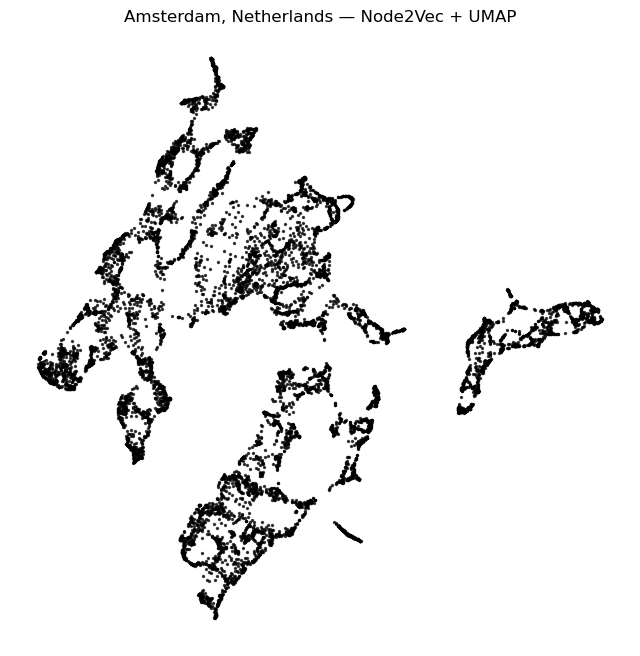

In [4]:
import os, time, json
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import umap
from node2vec import Node2Vec

ox.settings.use_cache = True
ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"
network_dir = "networks"
os.makedirs(network_dir, exist_ok=True)

updated_cache = []
for entry in city_data:
    if entry["nam"] != "Amsterdam, Netherlands":
        continue

    name, coords, dist, ntw = entry["nam"], entry["crd"], entry["dst"], entry["ntw"]

    print(f"🔄 Fetching network for {name} (type={ntw}, r={dist} m)…")
    G = ox.graph_from_point(coords, dist=dist, network_type=ntw)

    Gu = nx.Graph(G)
    H = Gu.subgraph(max(nx.connected_components(Gu), key=len)).copy()

    # --- node2vec embedding ---
    print("🧩 Running node2vec…")
    n2v = Node2Vec(H, dimensions=64, walk_length=30, num_walks=200, workers=2, seed=42)
    model = n2v.fit(window=10, min_count=1, batch_words=4)

    nodes = list(H.nodes())
    X = np.array([model.wv[str(node)] for node in nodes])

    # --- UMAP projection ---
    print("🔮 Running UMAP projection…")
    embed = umap.UMAP(
        n_neighbors=50,
        min_dist=0.05,
        metric="cosine",
        random_state=42
    ).fit_transform(X)

    # --- plot ---
    plt.figure(figsize=(8, 8))
    plt.scatter(embed[:, 0], embed[:, 1], s=2, c="black", alpha=0.7)
    plt.axis("off")
    plt.title(f"{name} — Node2Vec + UMAP", fontsize=12)
    plt.show()

    updated_cache.append(entry)
    time.sleep(1)

In [ ]:
comparison_images = []

for entry in city_data:
    group = entry["grp"]
    taxonomy = entry["tax"]
    name = entry["nam"]
    coords = entry["crd"]
    filename = name.replace(', ', '_').replace(' ', '_') + ".png"

    taxonomy_path = os.path.join(taxonomy_dir, f"{taxonomy}.jpg")
    city_path = os.path.join(image_dir, filename)

    if not os.path.exists(taxonomy_path) or not os.path.exists(city_path):
        print(f"❌ Missing: {taxonomy} or {name}")
        continue

    tax_img = Image.open(taxonomy_path).resize(thumb_size)
    city_img = Image.open(city_path).resize(thumb_size)

    panel = Image.new("RGB", (panel_width, panel_height), "white")
    draw = ImageDraw.Draw(panel)
    
    # Paste images
    x1, x2, y = 40, thumb_size[0] + 2 * 40, 100
    panel.paste(tax_img, (x1, y))
    panel.paste(city_img, (x2, y))

    # Draw group title at the top
    group_text = group
    xg = panel_width // 2 - draw.textlength(group_text, font=title_font) // 2
    draw.text((xg, 20), group_text, font=title_font, fill="black")

    # Draw labels below thumbnails
    draw.text((x1, y + thumb_size[1] + 10), taxonomy, font=font, fill="black")
    draw.text((x2, y + thumb_size[1] + 10), name, font=font, fill="black")
    draw.text((x2, y + thumb_size[1] + 10 + font_size), f"({coords[0]:.4f}, {coords[1]:.4f})", font=font, fill="gray")

    comparison_images.append(panel)
    print(f"✅ Panel created: {taxonomy} vs {name}")

✅ Panel created: Radial Implosion vs Rome, Italy
✅ Panel created: Elliptical Implosion vs Vatican City
✅ Panel created: Organic Rhizome vs Fez, Morocco
✅ Panel created: Centralized Burst vs Moscow, Russia
✅ Panel created: Arc Diagram vs Medellín, Colombia
✅ Panel created: Radial Convergence vs Palmanova, Italy
✅ Panel created: Segmented Radial Convergence vs Dubai, UAE
✅ Panel created: Centralized Ring vs Canberra, Australia
✅ Panel created: Flow Chart vs Los Angeles, USA
✅ Panel created: Area Grouping vs Randstad, Netherlands
✅ Panel created: Circular Ties vs Greater Cairo, Egypt
✅ Panel created: Ramification vs Amsterdam, Netherlands


In [ ]:
if comparison_images:
    comparison_images[0].save(
        pdf_output,
        save_all=True,
        append_images=comparison_images[1:],
        format="PDF"
    )
    print(f"📄 Exported to: {pdf_output}")
else:
    print("⚠️ No panels to export.")


📄 Exported to: comparison.pdf
